In [38]:
import os
import pandas as pd
import joblib

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd



def plot_all_vs_ori(merged_names, ref_name="merged_ori", num_xticks=10):
    """
    Plot perbandingan rata-rata antara setiap DataFrame preprocessing dengan 'merged_ori'.
    Kolom 'FENOL' otomatis di-drop jika ada.
    
    Parameter:
    - merged_names : list nama semua DataFrame merged (hasil fungsi merge_cal_val)
    - ref_name     : nama DataFrame acuan (default = 'merged_ori')
    - num_xticks   : jumlah tick di sumbu X
    """

    # Pastikan DataFrame acuan tersedia
    ref_df = globals().get(ref_name)
    if not isinstance(ref_df, pd.DataFrame):
        raise ValueError(f"DataFrame referensi '{ref_name}' tidak ditemukan di variabel global.")

    # Drop kolom 'FENOL' jika ada
    if "FENOL" in ref_df.columns:
        ref_df = ref_df.drop(columns=["FENOL"])

    # Filter semua nama selain acuan
    target_names = [name for name in merged_names if name != ref_name]

    # Loop setiap DataFrame untuk dibandingkan
    for target_name in target_names:
        target_df = globals().get(target_name)
        if not isinstance(target_df, pd.DataFrame):
            print(f"⚠️  {target_name} tidak ditemukan atau bukan DataFrame, dilewati.")
            continue

        # Drop kolom 'FENOL' jika ada
        if "FENOL" in target_df.columns:
            target_df = target_df.drop(columns=["FENOL"])

        # Ambil kolom yang sama
        common_cols = ref_df.columns.intersection(target_df.columns)
        ref_sub = ref_df[common_cols]
        tgt_sub = target_df[common_cols]

        # Ubah ke float (anggap kolom = panjang gelombang)
        try:
            x_vals = common_cols.astype(float)
        except Exception:
            raise ValueError("Kolom harus berupa angka (atau dapat dikonversi ke float).")

        # Hitung rata-rata tiap kolom
        ref_avg = ref_sub.mean()
        tgt_avg = tgt_sub.mean()

        # Plot
        plt.figure(figsize=(10, 6))
        plt.plot(x_vals, ref_avg, label="ORI", linewidth=2)
        plt.plot(x_vals, tgt_avg, label=target_name.replace("merged_", "").upper(), linewidth=2)

        tick_positions = np.linspace(x_vals.min(), x_vals.max(), num_xticks)
        tick_positions = np.round(tick_positions).astype(int)
        plt.xticks(tick_positions)

        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Reflectance")
        plt.title(f"Comparison: ORI vs {target_name.replace('merged_', '').upper()}")
        plt.legend()
        plt.grid(True, linestyle="--", alpha=0.6)
        plt.tight_layout()
        plt.show()

In [40]:
import pandas as pd

def merge_cal_val(file_list):
    merged_names = []  # untuk menyimpan nama merged dataframe
    base_names = sorted({f.replace('cal_', '').replace('val_', '').replace('.csv', '') for f in file_list})

    for name in base_names:
        cal_name = f"cal_{name}"
        val_name = f"val_{name}"

        cal_df = globals().get(cal_name)
        val_df = globals().get(val_name)

        if isinstance(cal_df, pd.DataFrame) and isinstance(val_df, pd.DataFrame):
            merged_df = pd.concat([cal_df, val_df], ignore_index=True)
            merged_name = f"merged_{name}"
            globals()[merged_name] = merged_df
            merged_names.append(merged_name)
            # print(f"✅ DataFrame '{merged_name}' berhasil dibuat ({len(merged_df)} baris).")
        else:
            print(f"⚠️  DataFrame '{cal_name}' atau '{val_name}' tidak ditemukan.")

    return merged_names


In [41]:
import pandas as pd
import numpy as np

def scale_merged_individual_global(merged_names, drop_cols, scaled_prefix=""):
    """
    Lakukan min–max scaling (0–1) untuk setiap DataFrame secara keseluruhan (bukan per kolom).
    Setiap DataFrame di-scale secara independen.
    Drop kolom 'FENOL' jika ada.
    Hasil disimpan sebagai variabel global bernama scaled_<original_name>.
    Return: list nama variabel yang dibuat.
    """

    created = []

    for name in merged_names:
        df = globals().get(name)
        if not isinstance(df, pd.DataFrame):
            print(f"⚠️  '{name}' tidak ditemukan atau bukan DataFrame — dilewati.")
            continue

        df_tmp = df.copy()

        # Drop kolom jika ada
        for col in drop_cols:
            if col in df_tmp.columns:
                df_tmp = df_tmp.drop(columns=[col])

        # Ambil hanya nilai numerik
        numeric_df = df_tmp.select_dtypes(include=[np.number])
        if numeric_df.empty:
            print(f"⚠️  '{name}' tidak memiliki kolom numerik — dilewati.")
            continue

        # Hitung min dan max global untuk seluruh DataFrame
        global_min = numeric_df.min().min()
        global_max = numeric_df.max().max()

        if global_min == global_max:
            scaled_df = numeric_df * 0.0
            print(f"⚠️  '{name}' memiliki nilai konstan — diisi 0.0 semua.")
        else:
            scaled_df = (numeric_df - global_min) / (global_max - global_min)

        scaled_name = f"{scaled_prefix}{name}"
        globals()[scaled_name] = scaled_df
        created.append(scaled_name)

        # print(f"✅ '{scaled_name}' dibuat | min={scaled_df.min().min():.3f}, max={scaled_df.max().max():.3f}")

    return created


FENOL

Total DataFrame yang dibuat: 22


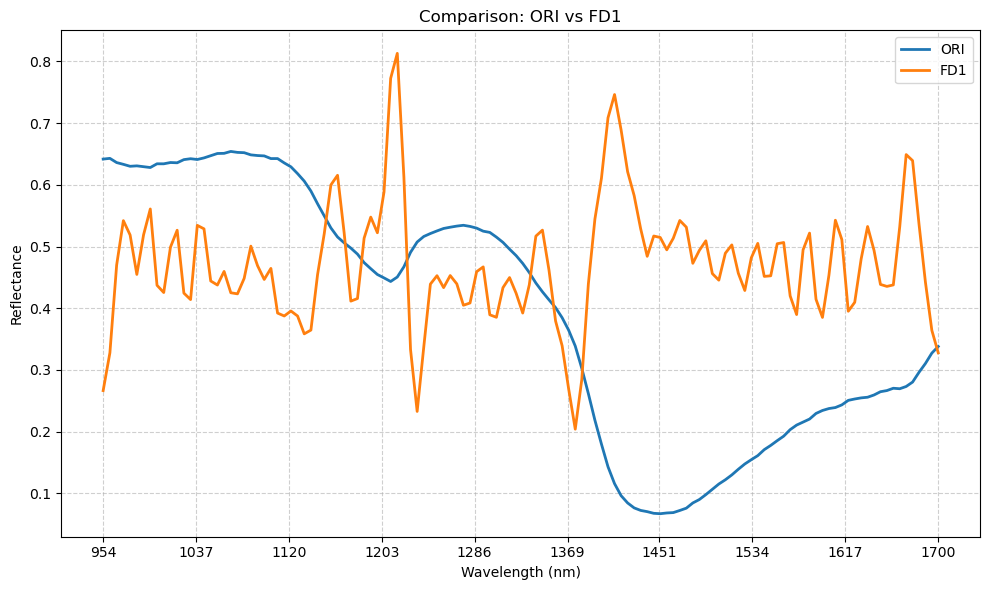

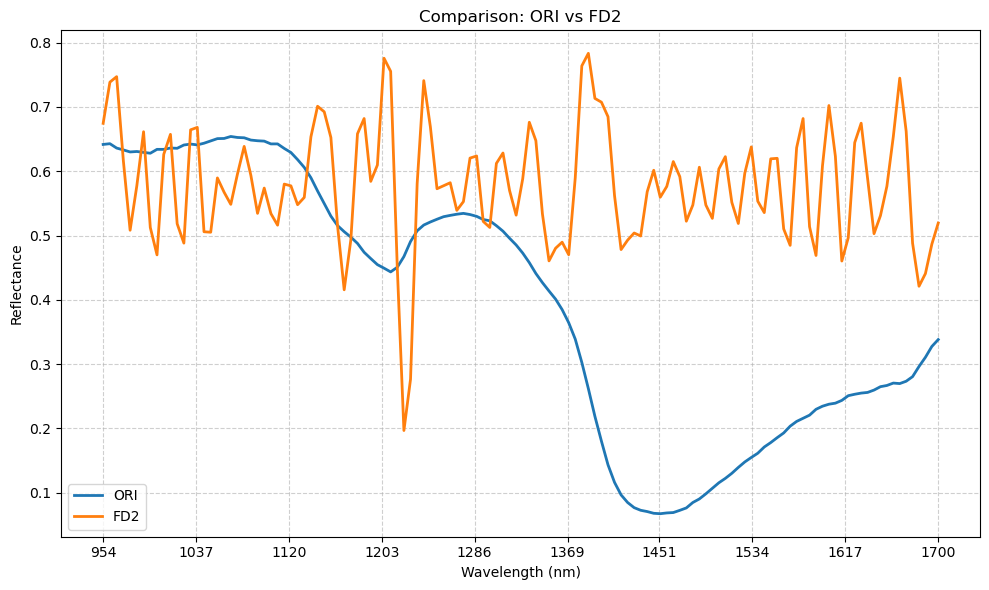

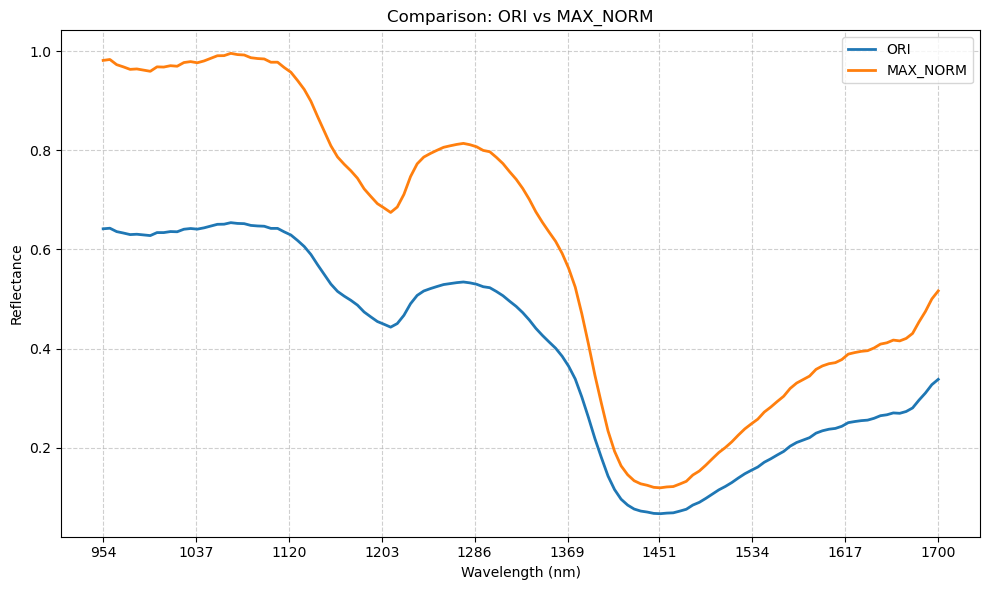

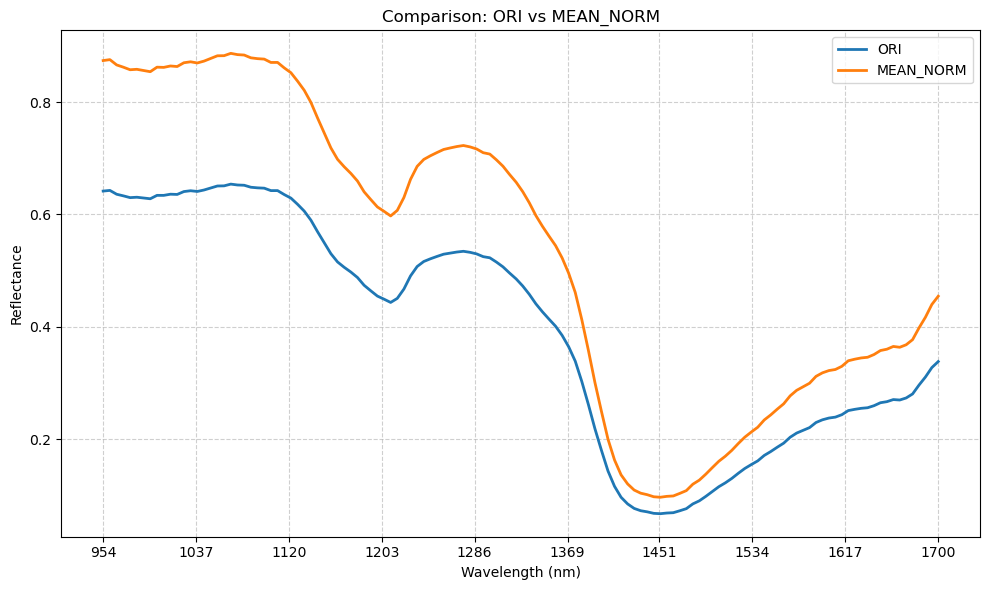

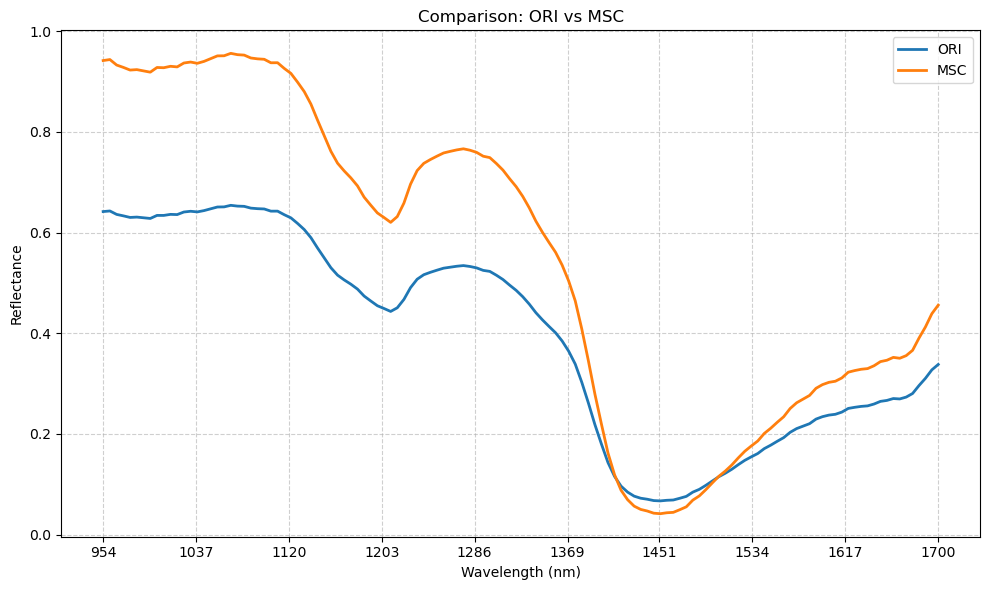

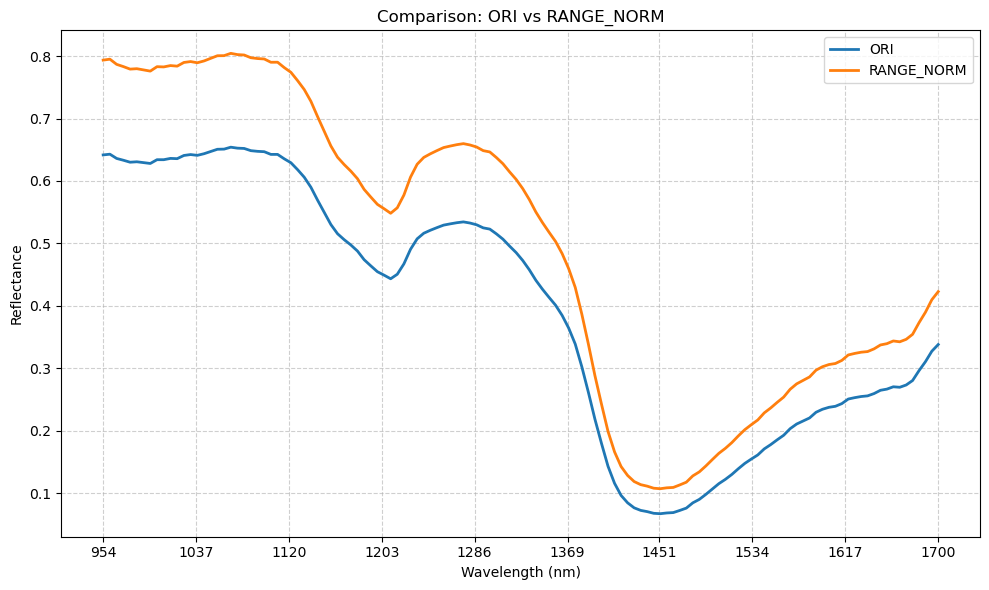

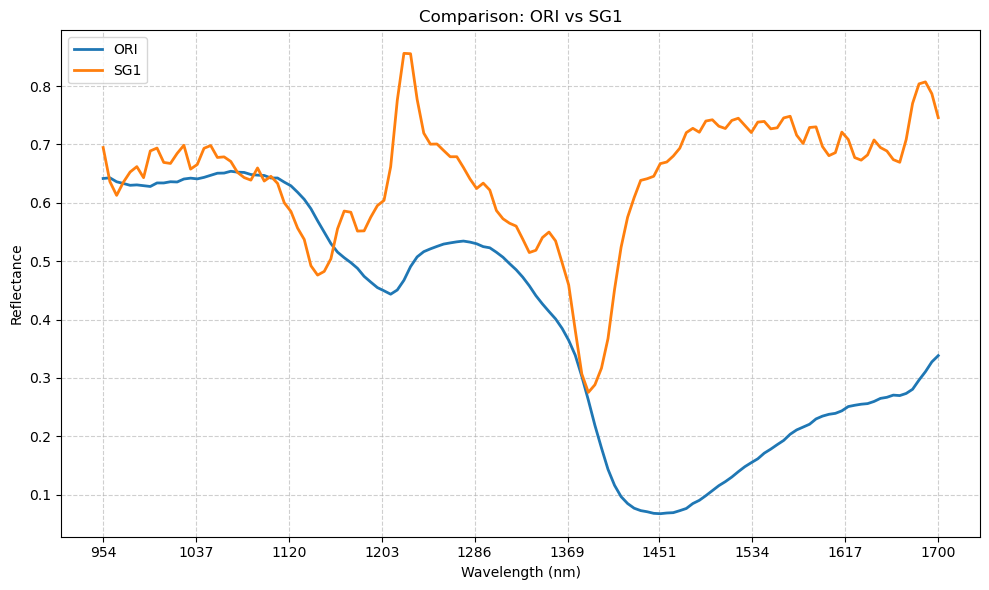

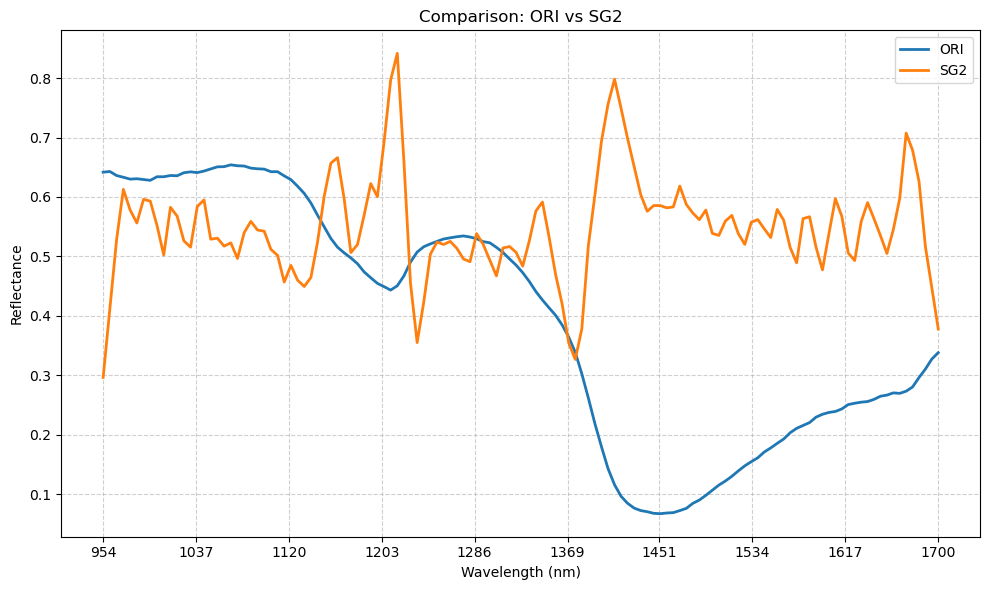

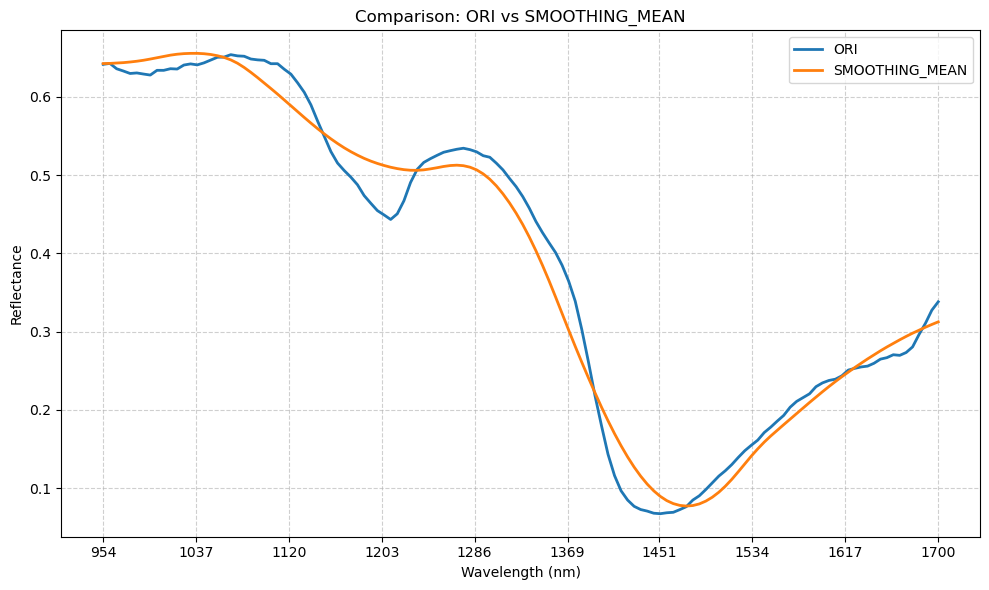

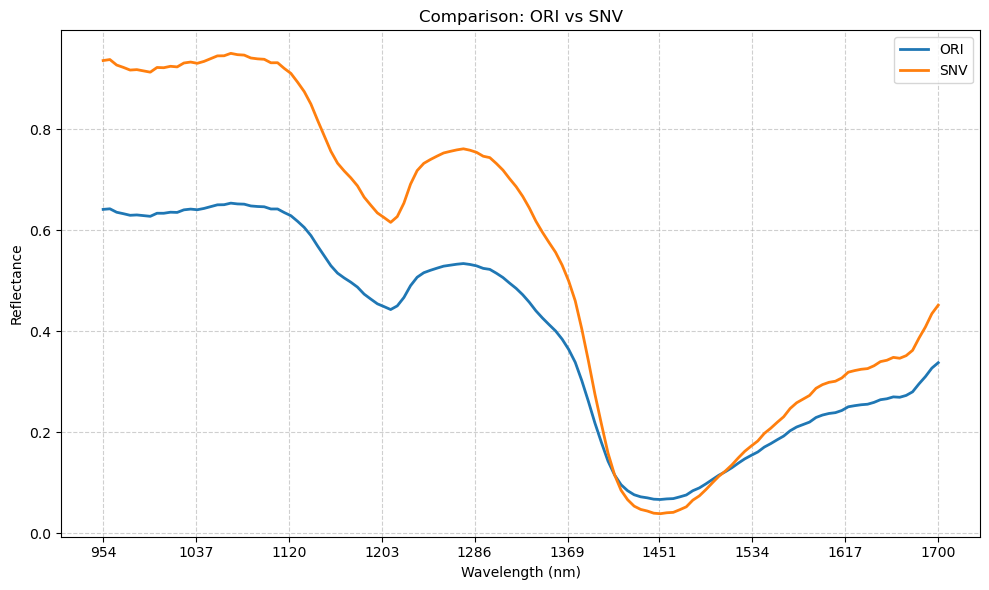

In [42]:

# Path ke folder data
data_dir = '../../../prepossed_curated_data_2/basah/nir/fenol'

# Membaca semua file CSV di folder
files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]

# Membuat DataFrame untuk setiap file
for file in files:
    df_name = file.split('.')[0]  # Nama DataFrame berdasarkan nama file
    globals()[df_name] = pd.read_csv(os.path.join(data_dir, file))

# Verifikasi jumlah DataFrame yang dibuat
print(f"Total DataFrame yang dibuat: {len(files)}")

merged_files=merge_cal_val(files)
scaled_files=scale_merged_individual_global(merged_files, drop_cols=["FENOL"])
plot_all_vs_ori(scaled_files)



Gula Reduksi

Total DataFrame yang dibuat: 22


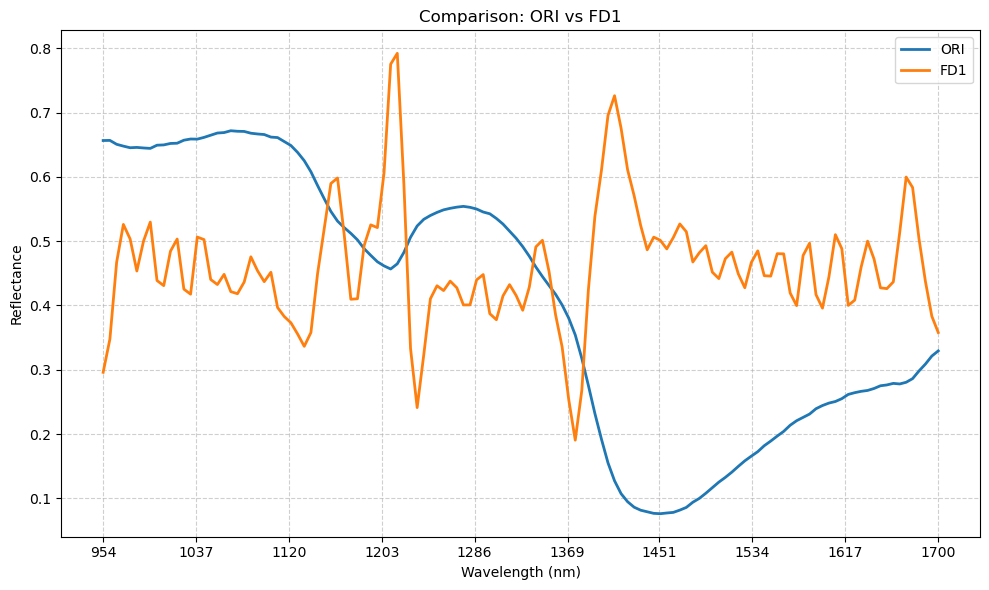

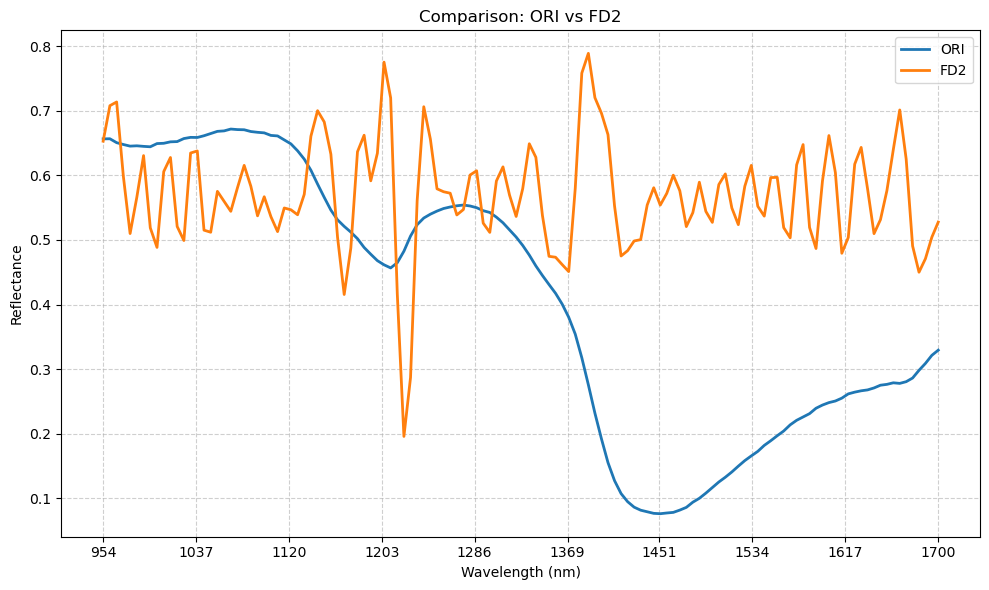

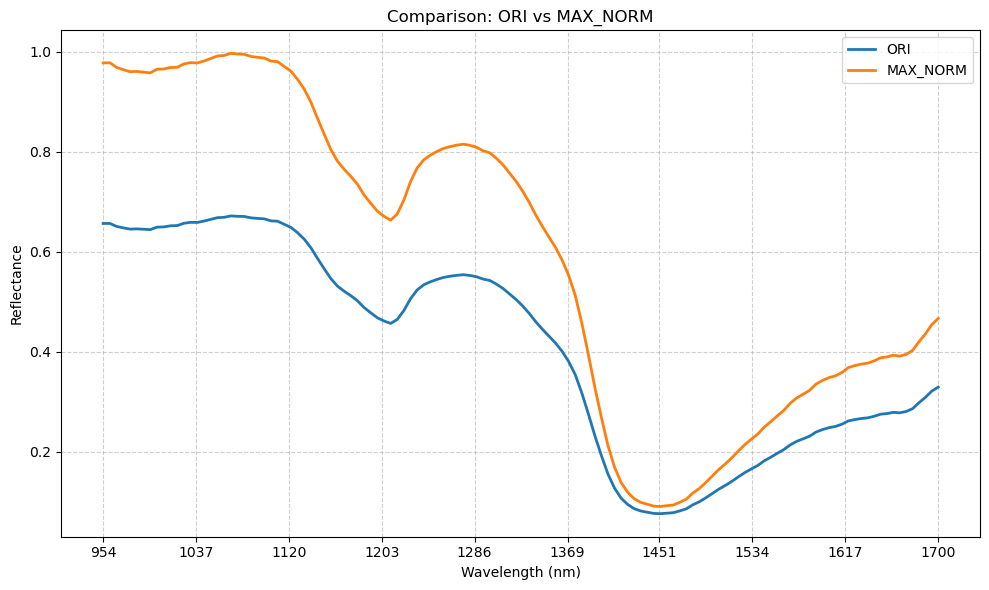

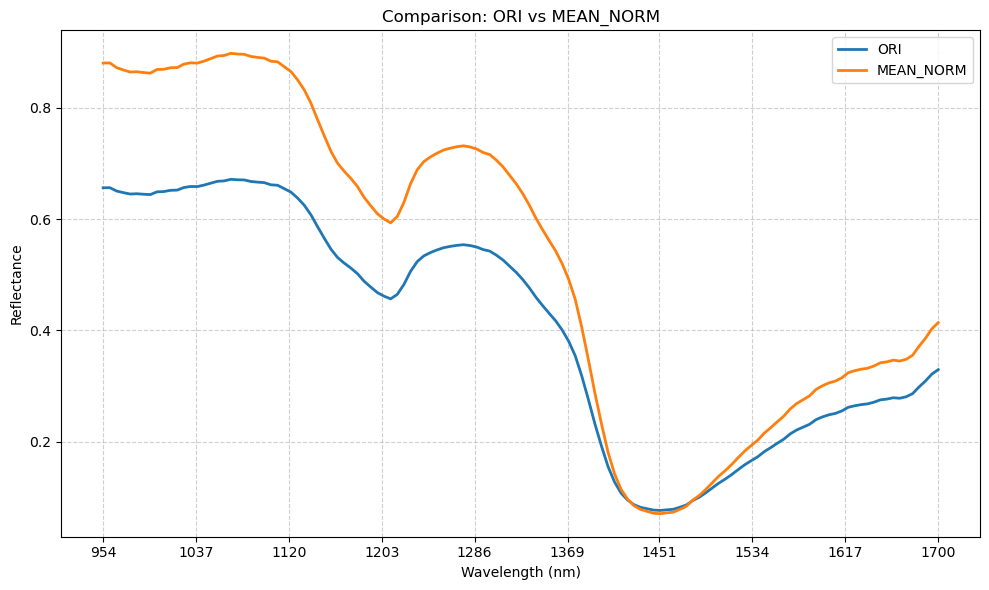

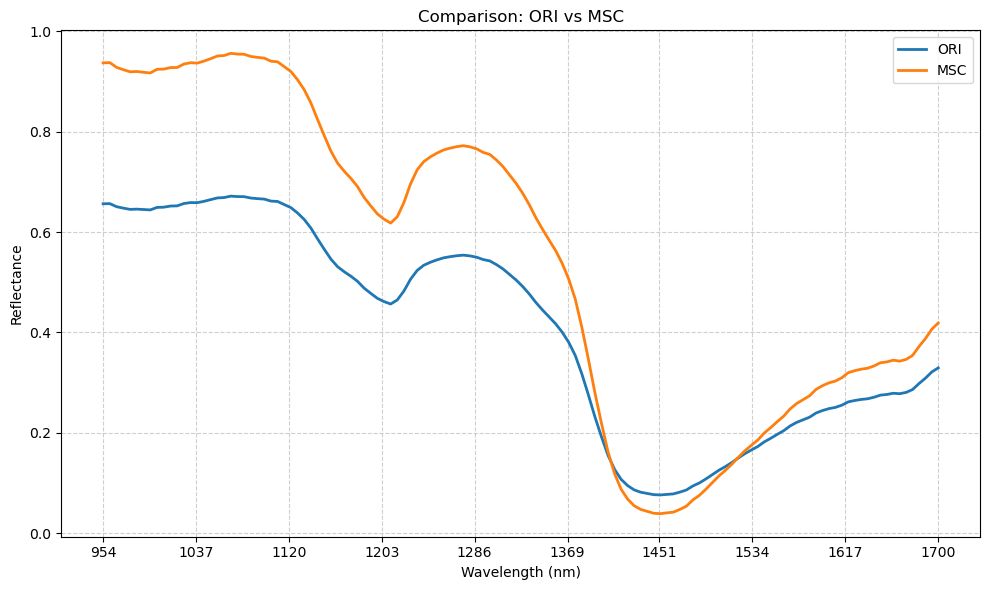

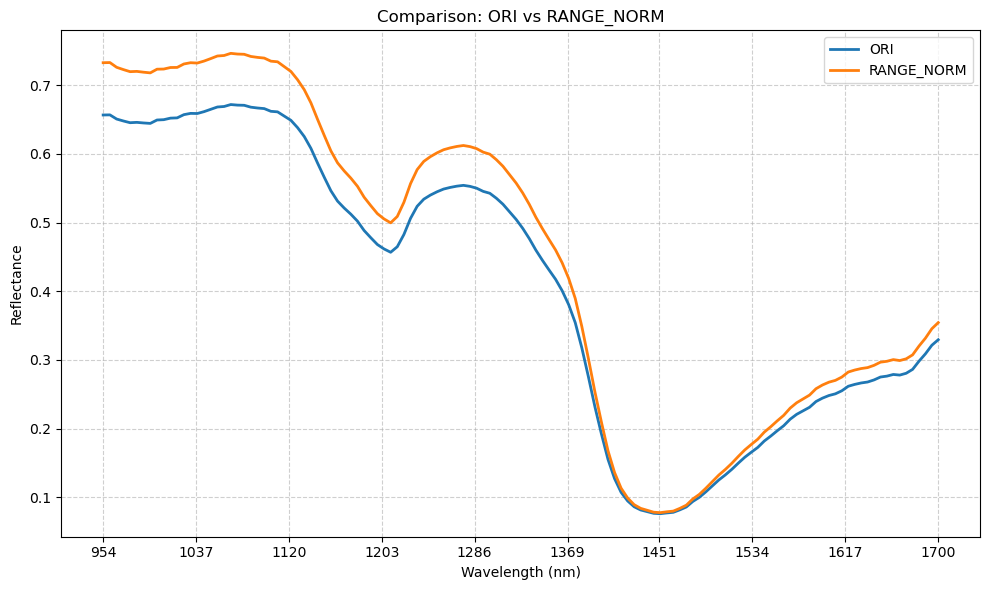

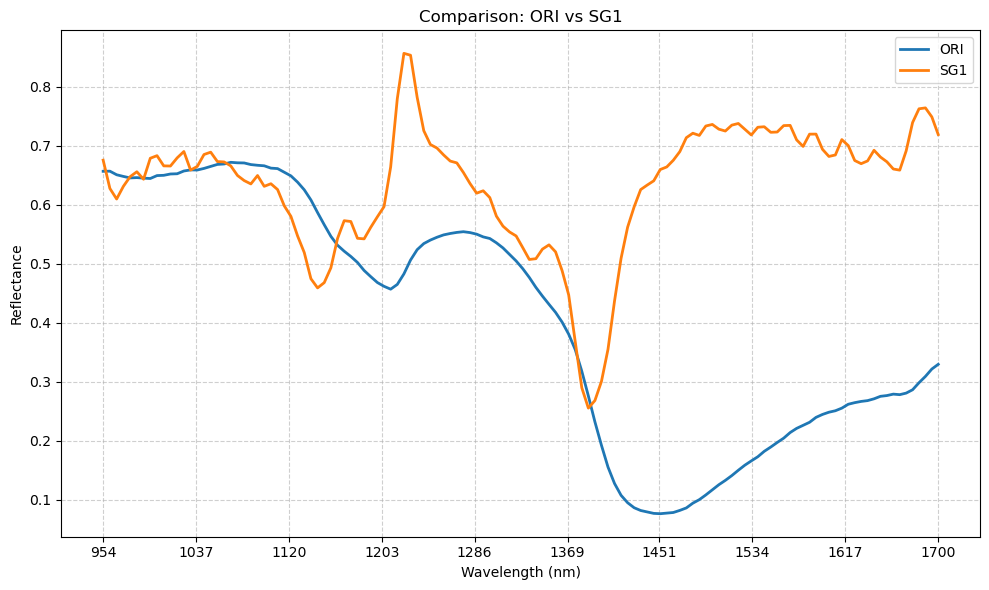

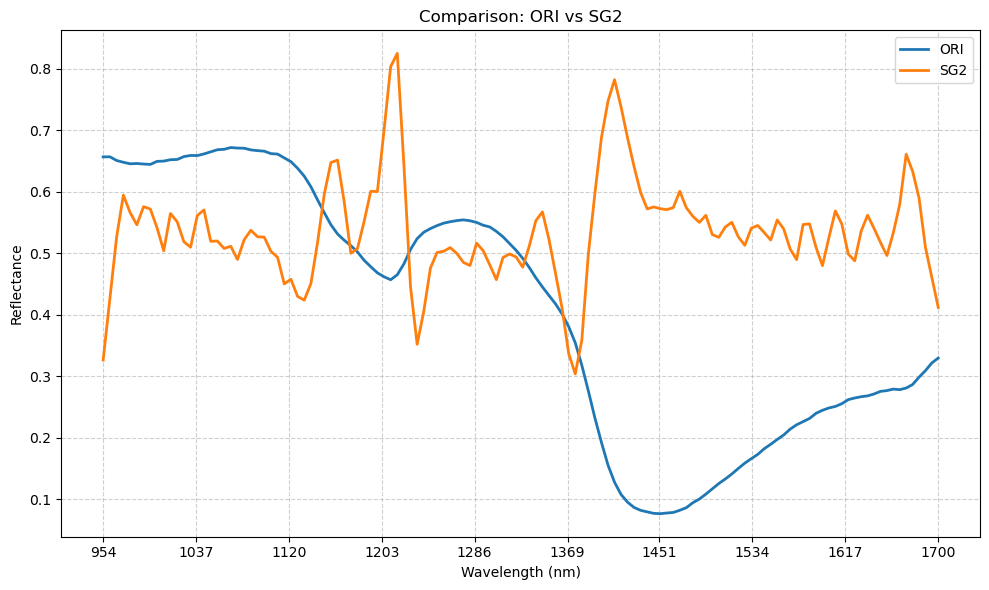

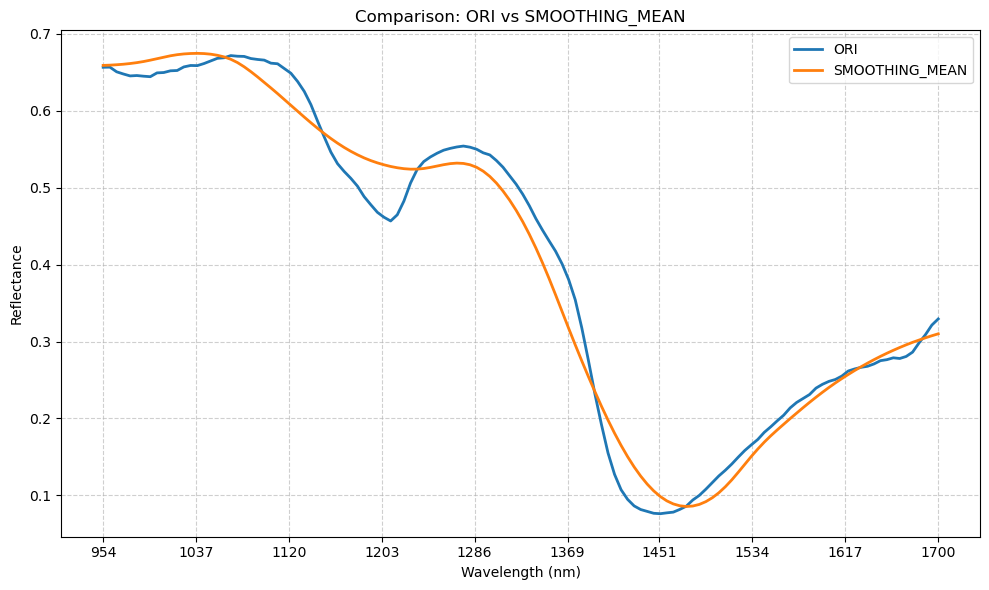

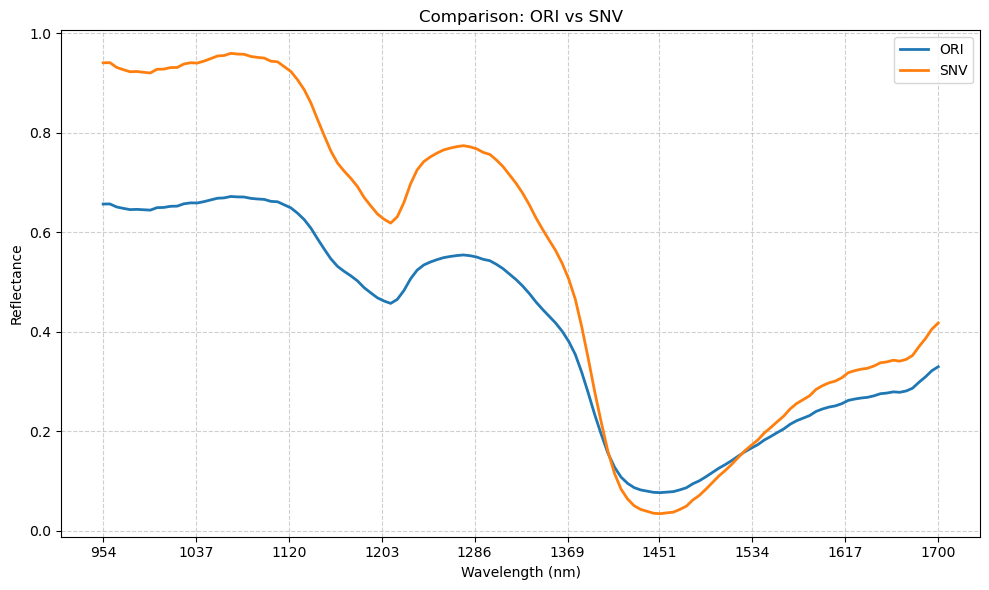

In [44]:

# Path ke folder data
data_dir = '../../../prepossed_curated_data_2/basah/nir/gula_reduksi'

# Membaca semua file CSV di folder
files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]

# Membuat DataFrame untuk setiap file
for file in files:
    df_name = file.split('.')[0]  # Nama DataFrame berdasarkan nama file
    globals()[df_name] = pd.read_csv(os.path.join(data_dir, file))

# Verifikasi jumlah DataFrame yang dibuat
print(f"Total DataFrame yang dibuat: {len(files)}")

merged_files=merge_cal_val(files)
scaled_files=scale_merged_individual_global(merged_files,drop_cols=["Gula Reduksi"])
plot_all_vs_ori(scaled_files)

